In [1]:
import numpy as np
import scipy
import math
import json
import mthree
import pylatexenc
from itertools import product
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import random_unitary
from qiskit.quantum_info.operators import Operator
from qiskit.circuit import Gate
from qiskit.quantum_info import Statevector
from qiskit import transpile
from qiskit.circuit.library import Permutation, UnitaryGate, ECRGate
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeBrisbane, FakeKyiv, FakeSherbrooke
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import matplotlib.pyplot as plt
from qiskit_aer.noise import NoiseModel

In [ ]:
# IBM access
QiskitRuntimeService.save_account(channel="ibm_quantum", token="", overwrite=True, set_as_default=True)
service = QiskitRuntimeService()
real_backend = service.backend("ibm_brisbane")
fake_backend = AerSimulator.from_backend(real_backend)
_ideal_backend = AerSimulator()
noise_model = NoiseModel.from_backend(_ideal_backend)
fake_backend_clear = AerSimulator.from_backend(real_backend, noise_model=noise_model)

In [3]:
# params
my_backend = fake_backend_clear
N_factor = 4
G = 6

In [4]:
# generate results
real_sampler = SamplerV2(mode=my_backend)

N = (2**N_factor)*G
qc_list = []
qubits_list = []

phi0 = -np.pi / (2*N)
phi1 = np.pi / (2*N)

for b_factor in range(N_factor+1):
    b = 2**b_factor
    a = N // b
    
    qc = QuantumCircuit(b)
    qc.h(0)
    for i in range(1,b):
        qc.cx(i-1, i)
    
    for i in range(b):
        qc.sx(i)
        qc.x(i)
    for _ in range(a):
        qc.barrier()
        for i in range(b):
            qc.sx(i)
            qc.rz(phi0, i)
            qc.sx(i)
        qc.barrier()
        for i in range(b):
            qc.x(i)
    for i in range(b):
        qc.sx(i)
        
    qc.rz(np.pi/2, 0)
    for i in range(b):
        qc.rz(np.pi/2, i)
        qc.sx(i)
    qc.measure_all()
    transpiled_qc = transpile(qc, my_backend, optimization_level=3)
    qc_list.append(transpiled_qc)
    qubits_list.append(transpiled_qc.layout.final_index_layout(0)[0:b])
    
    qc = QuantumCircuit(b)
    qc.h(0)
    for i in range(1,b):
        qc.cx(i-1, i)
    
    for i in range(b):
        qc.sx(i)
        qc.x(i)
    for _ in range(a):
        qc.barrier()
        for i in range(b):
            qc.sx(i)
            qc.rz(phi1, i)
            qc.sx(i)
        qc.barrier()
        for i in range(b):
            qc.x(i)
    for i in range(b):
        qc.sx(i)
        
    qc.rz(np.pi/2, 0)
    for i in range(b):
        qc.rz(np.pi/2, i)
        qc.sx(i)
    qc.measure_all()
    transpiled_qc = transpile(qc, my_backend, optimization_level=3)
    qc_list.append(transpiled_qc)
    qubits_list.append(transpiled_qc.layout.final_index_layout(0)[0:b])

jobs = real_sampler.run(qc_list, shots=10000)
results = [x.data.meas.get_counts() for x in jobs.result()]
with open(f"sx_{N_factor}_{G}.json", 'w') as f:
    json.dump(results+[qubits_list], f)

In [5]:
# process the results
probs_of_success = []
for x in range(N_factor+1):
    first = results[2*x]
    second = results[2*x + 1]
    p_temp = 0
    # first
    for key, value in first.items():
        if sum(int(xx) for xx in key)%2==0:
            p_temp += value

    # second
    for key, value in second.items():
        if sum(int(xx) for xx in key)%2!=0:
            p_temp += value
    p_temp = p_temp/(2*10000)
    probs_of_success.append(p_temp)

In [7]:
# mitigate
m3_probs_of_success = []
mit = mthree.M3Mitigation(my_backend)

for x in range(N_factor+1):
    p_temp = 0

    # first
    mit.cals_from_system(qubits_list[2*x], 10000)
    m3_quasi = mit.apply_correction(results[2*x], qubits_list[2*x])
    closest_probs = m3_quasi.nearest_probability_distribution()
    for key, value in closest_probs.items():
        if sum(int(xx) for xx in key)%2==0:
            p_temp += value

    # second
    mit.cals_from_system(qubits_list[2*x+1], 10000)
    m3_quasi = mit.apply_correction(results[2*x+1], qubits_list[2*x+1])
    closest_probs = m3_quasi.nearest_probability_distribution()
    for key, value in closest_probs.items():
        if sum(int(xx) for xx in key)%2!=0:
            p_temp += value

    p_temp = p_temp/2
    m3_probs_of_success.append(p_temp)

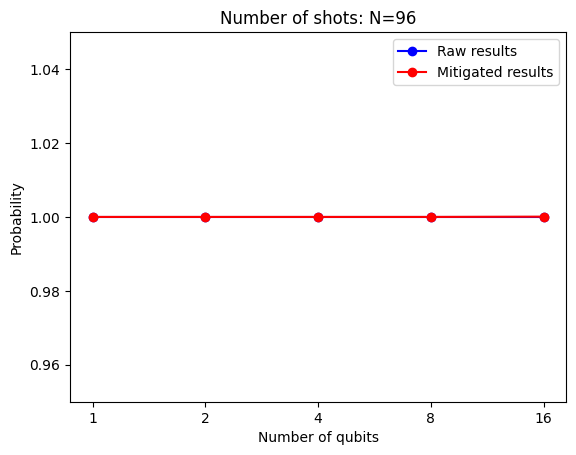

In [8]:
# draw
plt.plot(range(N_factor+1), probs_of_success, '-bo')
plt.plot(range(N_factor+1), m3_probs_of_success, '-ro')
plt.xticks(range(N_factor+1))
plt.ylim(0.95, 1.05)
plt.title(f"Number of shots: N={N}")
plt.legend(["Raw results", "Mitigated results"])
plt.xlabel("Number of qubits")
plt.xticks(range(N_factor+1),[2**xx for xx in range(N_factor+1)])
plt.ylabel("Probability")
plt.savefig(f"sx_{N_factor}_{G}.pdf", backend='pgf')

In [85]:
## SPECIAL TEST SUBOPTIMAL ALL FOR ONE
# params
my_backend = fake_backend_clear
b = 2
a = 32

real_sampler = SamplerV2(mode=my_backend)

N = a*b
qc_list = []

phi0 = -np.pi / (2*N)
phi1 = np.pi / (2*N)

qc = QuantumCircuit(b)
for i in range(b):
    qc.sx(i)
    qc.rz(np.pi/2, i)

for i in range(b):
    qc.sx(i)
    qc.x(i)

for _ in range(a):
    qc.barrier()
    for i in range(b):
        qc.sx(i)
        qc.rz(phi0, i)
        qc.sx(i)
    qc.barrier()
    for i in range(b):
        qc.x(i)
for i in range(b):
    qc.sx(i)

for i in range(b):
    qc.rz(np.pi, i)
    qc.sx(i)
qc.measure_all()
transpiled_qc = transpile(qc, my_backend, optimization_level=3)
qc_list.append(transpiled_qc)

qc = QuantumCircuit(b)
for i in range(b):
    qc.sx(i)
    qc.rz(np.pi/2, i)

for i in range(b):
    qc.sx(i)
    qc.x(i)

for _ in range(a):
    qc.barrier()
    for i in range(b):
        qc.sx(i)
        qc.rz(phi1, i)
        qc.sx(i)
    qc.barrier()
    for i in range(b):
        qc.x(i)
for i in range(b):
    qc.sx(i)

for i in range(b):
    qc.rz(np.pi, i)
    qc.sx(i)
qc.measure_all()
transpiled_qc = transpile(qc, my_backend, optimization_level=3)
qc_list.append(transpiled_qc)

jobs = real_sampler.run(qc_list, shots=10000)
results = [x.data.meas.get_counts() for x in jobs.result()]
# process the results
probs_of_success = 0
first = results[0]
second = results[1]
# first
for key, value in first.items():
    if sum(int(xx) for xx in key)<b/2:
        probs_of_success += value
    elif sum(int(xx) for xx in key)==b/2:
        probs_of_success += value/2

# second
for key, value in second.items():
    if sum(int(xx) for xx in key)>b/2:
        probs_of_success += value
    elif sum(int(xx) for xx in key)==b/2:
        probs_of_success += value/2

probs_of_success = probs_of_success/(2*10000)
print(probs_of_success)

0.853825
